# Product Category Identification for NIR Spectra

This notebook identifies the most probable **product/matrix category** for real NIRS datasets using a scientifically sound approach:

1. **Canonical representation** - Handles reflectance, absorbance, and derivative inputs
2. **Uniform grid resampling** - Handles irregular wavelength axes
3. **Matched filter scoring** - Uses band templates instead of peak picking  
4. **Composition fitting** - NNLS-based fitting for interpretable latent scores
5. **Family scoring** - Water, hydrocarbons, lipids, proteins, carbohydrates, minerals, pigments, alcohols
6. **Product mapping** - Maps family scores to product categories with mixture support
7. **Confidence metrics** - Evidence-based thresholds with wavelength-range awareness

## Product Categories

- **petroleum/hydrocarbons** - Fuels, oils (1712nm C-H, 1390nm methyl)
- **alcoholic/fermented** - Beers, wines (2270nm C-O ethanol, 1580nm O-H)
- **starch/grain/carbohydrate** - Starch, cereals (2100nm O-H, 2280nm starch)
- **lipid-rich/fats** - Dairy, oils (1760nm ester C=O, 1720nm C-H)
- **soil/mineral_matrix** - Soils, clays (2200nm Al-OH, 2330nm carbonate)
- **plant/vegetation** - Leaves, plants (670nm chlorophyll, 500nm carotenoid)
- **protein-rich** - Meat, dairy protein (2050nm N-H, 1510nm amide)

## Ground Truth (7 definite)

| Dataset | Expected Category | Product Family |
|---------|-------------------|----------------|
| Beer | alcoholic/fermented | alcohols |
| Biscuit | lipid-rich/fats | lipids |
| Diesel | petroleum/hydrocarbons | hydrocarbons |
| LUCAS_SOC | soil/mineral_matrix | minerals |
| Milk | lipid-rich/fats | lipids |
| Rice | starch/grain/carbohydrate | carbohydrates |
| Corn | starch/grain/carbohydrate | carbohydrates |
| Grapevine | *uncertain* | chloride on leaves |
| Poultry_manure | *uncertain* | CaO on animal waste |
| TABLET | *uncertain* | pharmaceutical |

In [ ]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

# Import the product category detector
from dataset_category_identifier import (
    DATASET_NAMES,
    FAMILY_BAND_TEMPLATES,
    GROUND_TRUTH,
    PRODUCT_CATEGORIES,
    CanonicalType,
    CategoryPrediction,
    ConfidenceLevel,
    FamilyScore,
    IdentificationResult,
    RangeCoverage,
    canonicalize_spectra,
    identify_category,
    load_all_datasets,
    load_dataset,
    print_detailed_results,
    run_experiment,
)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 1. Run Identification Experiment

The `run_experiment()` function loads all datasets and identifies their product categories using:
- Canonical representation detection and conversion
- nirs4all's `OptimizedComponentFitter` for composition analysis
- Rule-based product category mapping

In [4]:
# Run the full identification experiment
results, accuracy = run_experiment()

Loading datasets...
Loaded 10 datasets

Dataset                             Expected        Predicted       Score      Result
Beer                                alcohols        alcohols        20.58      OK
Biscuit                             carbohydrates   carbohydrates   33.47      OK
DIESEL                              petroleum       petroleum       14.67      OK
grapevine                           uncertain       pigments        13.14      n/a
LUCAS                               minerals        minerals        35.74      OK
Milk                                lipids          lipids          6.09       OK
Poultry                             uncertain       minerals        19.27      n/a
Rice                                carbohydrates   carbohydrates   1.90       OK
Corn                                carbohydrates   carbohydrates   42.01      OK
TABLET                              pharmaceutical  petroleum       11.37      WRONG

Accuracy on definite datasets: 7/8 (87.5%)


## 2. Detailed Results

Show family scores, product scores, and band evidence for each dataset.
The new API provides rich structured results with:
- `family_scores`: Dict mapping family name to `FamilyScore` with score and evidence coverage
- `product_scores`: List of `CategoryPrediction` sorted by score
- `mixture_categories`: Top categories with weights when ambiguous
- `confidence`: ConfidenceLevel (HIGH/MEDIUM/LOW/UNKNOWN) 
- `limitation_notes`: Warnings about missing wavelength regions

In [ ]:
# Print detailed results for each dataset
print_detailed_results(results)

## 3. Summary Table

In [ ]:
# Create summary DataFrame with new API structure
summary_data = []

for result in results:
    top_score = result.product_scores[0].score if result.product_scores else 0.0

    # Get top family
    if result.family_scores:
        top_family = max(result.family_scores.items(), key=lambda x: x[1].score)
        top_family_name = top_family[0]
        top_family_score = top_family[1].score
    else:
        top_family_name = "n/a"
        top_family_score = 0.0

    summary_data.append({
        'Dataset': result.dataset_name.split('_')[0],
        'WL Range': f"{result.wavelength_range[0]:.0f}-{result.wavelength_range[1]:.0f}",
        'Canonical': result.canonical_type.value[:8],
        'Top Family': f"{top_family_name} ({top_family_score:.2f})",
        'Predicted': result.predicted_category,
        'Expected': result.expected_category or 'uncertain',
        'Conf': result.confidence.value,
        'Score': f"{top_score:.2f}",
        'Status': '✓' if result.is_correct else ('?' if result.is_correct is None else '✗'),
    })

df_summary = pd.DataFrame(summary_data)
print("\n" + "=" * 140)
print("IDENTIFICATION SUMMARY")
print("=" * 140)
print(df_summary.to_string(index=False))
print("=" * 140)
print(f"\nAccuracy: {accuracy*100:.1f}%")

# Show limitation notes for any wrong predictions
wrong = [r for r in results if r.is_correct is False]
if wrong:
    print("\nLimitations for wrong predictions:")
    for r in wrong:
        print(f"  {r.dataset_name.split('_')[0]}: {r.limitation_notes}")

## 4. Visualization: Product Category Scores per Dataset

The new API provides `product_scores` as a list of `CategoryPrediction` objects with scores for each product category.

In [ ]:
def plot_product_scores(result, ax=None):
    """Bar chart of product category scores for a single dataset."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    # Get product scores
    scores = result.product_scores
    if not scores:
        ax.text(0.5, 0.5, 'No categories matched', ha='center', va='center', transform=ax.transAxes)
        return ax

    # Filter to scores > 0
    scores = [s for s in scores if s.score > 0]
    if not scores:
        ax.text(0.5, 0.5, 'No categories with positive score', ha='center', va='center', transform=ax.transAxes)
        return ax

    cats = [s.category for s in scores]
    score_vals = [s.score for s in scores]

    colors = ['coral' if c == result.predicted_category else 'steelblue' for c in cats]
    bars = ax.barh(range(len(cats)), score_vals, color=colors)

    # Add confidence as text
    for i, (score, cat) in enumerate(zip(score_vals, cats, strict=False)):
        label = f'{score:.2f}'
        if cat == result.predicted_category:
            label += f' ({result.confidence.value})'
        ax.text(score + 0.02, i, label, va='center', fontsize=9)

    ax.set_yticks(range(len(cats)))
    ax.set_yticklabels(cats)
    ax.set_xlabel('Score')

    short_name = result.dataset_name.split('_')[0]
    status = '✓' if result.is_correct else ('?' if result.is_correct is None else '✗')
    ax.set_title(f"{short_name} {status}")
    ax.invert_yaxis()

    return ax


# Plot all datasets
n_datasets = len(results)
fig, axes = plt.subplots(n_datasets, 1, figsize=(10, 3 * n_datasets))
axes = axes.flatten()

for i, result in enumerate(results):
    plot_product_scores(result, ax=axes[i])

plt.tight_layout()
plt.show()

## 5. Family Scores Heatmap

The `family_scores` dict provides scores for each chemical family (water, lipids, proteins, etc.).
Each `FamilyScore` includes the score and evidence coverage (fraction of bands in measurement range).

In [ ]:
# Get all unique families with non-zero scores
all_families = set()
for result in results:
    for family, fs in result.family_scores.items():
        if fs.score > 0:
            all_families.add(family)

all_families = sorted(all_families)

# Build heatmap matrix for family scores
heatmap_data = np.zeros((len(results), len(all_families)))
dataset_names = []

for i, result in enumerate(results):
    dataset_names.append(result.dataset_name.split('_')[0])
    for j, family in enumerate(all_families):
        if family in result.family_scores:
            heatmap_data[i, j] = result.family_scores[family].score

# Normalize per row for better visualization
row_maxes = heatmap_data.max(axis=1, keepdims=True)
row_maxes[row_maxes == 0] = 1
heatmap_norm = heatmap_data / row_maxes

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(heatmap_norm, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(all_families)))
ax.set_xticklabels(all_families, rotation=45, ha='right')
ax.set_yticks(range(len(dataset_names)))
ax.set_yticklabels(dataset_names)

ax.set_xlabel('Chemical Family')
ax.set_ylabel('Dataset')
ax.set_title('Family Scores Across Datasets (Row-Normalized)')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Score')

# Add text annotations
for i in range(len(dataset_names)):
    for j in range(len(all_families)):
        if heatmap_data[i, j] > 0:
            text_color = 'white' if heatmap_norm[i, j] > 0.5 else 'black'
            ax.text(j, i, f"{heatmap_data[i, j]:.2f}", ha='center', va='center',
                   fontsize=8, color=text_color)

plt.tight_layout()
plt.show()

## 5b. Chemical Composition Analysis (Pie Charts)

Each dataset's spectral signature is decomposed into chemical families. The pie charts show the **relative composition (%)** of detected families, with a confidence indicator.

In [ ]:
def plot_composition_pie(result, ax):
    """Pie chart showing family composition percentages with confidence."""
    # Get family scores and filter to positive values
    family_data = [(name, fs.score) for name, fs in result.family_scores.items() if fs.score > 0]

    if not family_data:
        ax.text(0.5, 0.5, 'No families detected', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(result.dataset_name.split('_')[0])
        return

    # Sort by score descending
    family_data.sort(key=lambda x: -x[1])

    # Take top 6 families, group rest as "Other"
    if len(family_data) > 6:
        top_families = family_data[:6]
        other_score = sum(score for _, score in family_data[6:])
        if other_score > 0:
            top_families.append(("other", other_score))
        family_data = top_families

    names = [name for name, _ in family_data]
    scores = [score for _, score in family_data]

    # Normalize to percentages
    total = sum(scores)
    percentages = [s / total * 100 for s in scores]

    # Color palette
    colors = plt.cm.Set3(np.linspace(0, 1, len(names)))

    # Create pie chart
    wedges, texts, autotexts = ax.pie(
        percentages,
        labels=None,
        autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',
        colors=colors,
        startangle=90,
        pctdistance=0.75
    )

    # Add legend
    legend_labels = [f'{name} ({pct:.1f}%)' for name, pct in zip(names, percentages, strict=False)]
    ax.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    # Title with prediction and confidence
    short_name = result.dataset_name.split('_')[0]
    conf_color = {'high': 'green', 'medium': 'orange', 'low': 'red', 'unknown': 'gray'}
    conf = result.confidence.value
    status = '✓' if result.is_correct else ('?' if result.is_correct is None else '✗')

    ax.set_title(f"{short_name} {status}\n→ {result.predicted_category}\nConfidence: {conf} ({result.confidence_numeric:.0%})",
                 fontsize=10, color=conf_color.get(conf, 'black'))


# Create figure with subplots for all datasets
n_cols = 3
n_rows = (len(results) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

for i, result in enumerate(results):
    plot_composition_pie(result, axes[i])

# Hide empty subplots
for j in range(len(results), len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Chemical Family Composition by Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# Also create a summary table with percentages
print("\n" + "=" * 120)
print("CHEMICAL COMPOSITION SUMMARY (Top 5 families per dataset)")
print("=" * 120)

for result in results:
    short_name = result.dataset_name.split('_')[0]

    # Get and sort family scores
    family_data = [(name, fs.score, fs.evidence_coverage)
                   for name, fs in result.family_scores.items() if fs.score > 0]
    family_data.sort(key=lambda x: -x[1])

    # Normalize to percentages
    total = sum(s for _, s, _ in family_data)

    print(f"\n{short_name} [{result.confidence.value.upper()} confidence: {result.confidence_numeric:.0%}]")
    print(f"  Prediction: {result.predicted_category}")
    print("  Composition:")

    for name, score, coverage in family_data[:5]:
        pct = score / total * 100 if total > 0 else 0
        cov_str = f"(cov: {coverage:.0%})" if coverage < 1.0 else ""
        bar = "█" * int(pct / 5) + "░" * (20 - int(pct / 5))
        print(f"    {name:<15} {bar} {pct:5.1f}% {cov_str}")

## 6. Band Template Visualization

The detector uses band templates for each chemical family. Each template specifies:
- **center_nm**: Band center wavelength
- **sigma_nm**: Band width (for Gaussian matching)
- **weight**: Relative importance (0-1)
- **exclusivity**: How diagnostic for this family (1.0 = unique, 0.0 = shared)
- **assignment**: Chemical/vibrational assignment

The following visualization shows:
1. **Top**: Gaussian band profiles across the full spectral range (VIS + NIR), colored by chemical family
2. **Bottom**: Stacked bar chart showing band count per spectral region

In [ ]:
# Organize bands by wavelength region and family for visualization
import matplotlib.patches as mpatches

# Define spectral regions
SPECTRAL_REGIONS = {
    'VIS': (400, 780, '#E3F2FD'),     # Light blue
    'NIR1': (780, 1100, '#FFF3E0'),   # Light orange
    'NIR2': (1100, 1800, '#E8F5E9'),  # Light green
    'NIR3': (1800, 2600, '#FCE4EC'),  # Light pink
}

# Collect all bands with their family info
all_bands = []
for family, bands in FAMILY_BAND_TEMPLATES.items():
    for center, sigma, weight, exclusivity, assignment in bands:
        all_bands.append({
            'family': family,
            'center': center,
            'sigma': sigma,
            'weight': weight,
            'exclusivity': exclusivity,
            'assignment': assignment,
        })

# Sort by wavelength
all_bands = sorted(all_bands, key=lambda x: x['center'])

# Create a rich visualization
fig, axes = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [2, 1]})

# --- Top plot: Bands by wavelength with family coloring ---
ax1 = axes[0]

# Color palette for families
family_colors = {
    'water': '#2196F3',
    'hydrocarbons': '#795548',
    'lipids': '#FFC107',
    'proteins': '#9C27B0',
    'carbohydrates': '#4CAF50',
    'alcohols': '#FF5722',
    'minerals': '#607D8B',
    'pigments': '#E91E63',
    'organic_acids': '#00BCD4',
    'polymers': '#3F51B5',
    'pharmaceuticals': '#F44336',
}

# Add region backgrounds
for region_name, (wl_min, wl_max, color) in SPECTRAL_REGIONS.items():
    ax1.axvspan(wl_min, wl_max, alpha=0.15, color=color, label=f'{region_name}')
    ax1.text((wl_min + wl_max) / 2, 1.05, region_name, ha='center', va='bottom',
             fontsize=11, fontweight='bold', color='gray', transform=ax1.get_xaxis_transform())

# Plot each band as a Gaussian-like shape
for band in all_bands:
    color = family_colors.get(band['family'], 'gray')
    x = np.linspace(band['center'] - 3*band['sigma'], band['center'] + 3*band['sigma'], 100)
    # Height based on weight and exclusivity
    height = band['weight'] * (0.5 + 0.5 * band['exclusivity'])
    y = height * np.exp(-0.5 * ((x - band['center']) / band['sigma']) ** 2)
    ax1.fill(x, y, alpha=0.4, color=color, edgecolor=color, linewidth=1)
    ax1.plot([band['center'], band['center']], [0, height], color=color, linewidth=1, alpha=0.7)

# Add family legend
legend_patches = [mpatches.Patch(color=color, label=family, alpha=0.6)
                  for family, color in family_colors.items()]
ax1.legend(handles=legend_patches, loc='upper right', ncol=3, fontsize=9, framealpha=0.9)

ax1.set_xlim(400, 2600)
ax1.set_ylim(0, 1.2)
ax1.set_xlabel('Wavelength (nm)', fontsize=12)
ax1.set_ylabel('Band Strength (weight × exclusivity)', fontsize=12)
ax1.set_title('Chemical Family Band Templates Across Spectral Regions', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# --- Bottom plot: Band count per region per family (stacked bar) ---
ax2 = axes[1]

# Count bands per region per family
families = list(family_colors.keys())
regions = list(SPECTRAL_REGIONS.keys())
band_counts = {family: dict.fromkeys(regions, 0) for family in families}

for band in all_bands:
    for region, (wl_min, wl_max, _) in SPECTRAL_REGIONS.items():
        if wl_min <= band['center'] <= wl_max:
            band_counts[band['family']][region] += 1
            break

# Create stacked bar chart
x = np.arange(len(regions))
width = 0.6
bottom = np.zeros(len(regions))

for family in families:
    counts = [band_counts[family][r] for r in regions]
    if sum(counts) > 0:  # Only plot families with bands
        ax2.bar(x, counts, width, bottom=bottom, label=family,
                color=family_colors[family], alpha=0.7, edgecolor='white', linewidth=0.5)
        bottom += counts

ax2.set_xticks(x)
ax2.set_xticklabels([f'{r}\n({SPECTRAL_REGIONS[r][0]}-{SPECTRAL_REGIONS[r][1]}nm)' for r in regions])
ax2.set_ylabel('Number of Bands', fontsize=12)
ax2.set_title('Band Distribution by Spectral Region', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', ncol=4, fontsize=8, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 100)
print("BAND TEMPLATE SUMMARY BY SPECTRAL REGION")
print("=" * 100)
print(f"{'Family':<16} {'VIS':<8} {'NIR1':<8} {'NIR2':<8} {'NIR3':<8} {'Total':<8}")
print("-" * 100)
for family in families:
    counts = [band_counts[family][r] for r in regions]
    total = sum(counts)
    if total > 0:
        print(f"{family:<16} {counts[0]:<8} {counts[1]:<8} {counts[2]:<8} {counts[3]:<8} {total:<8}")
print("-" * 100)
totals = [sum(band_counts[f][r] for f in families) for r in regions]
print(f"{'TOTAL':<16} {totals[0]:<8} {totals[1]:<8} {totals[2]:<8} {totals[3]:<8} {sum(totals):<8}")

## 7. Spectra with Annotated Band Assignments

This visualization overlays the detected band positions on actual spectra, showing the chemical assignments for each band. The vertical lines indicate band centers, with annotations showing the vibrational assignment.

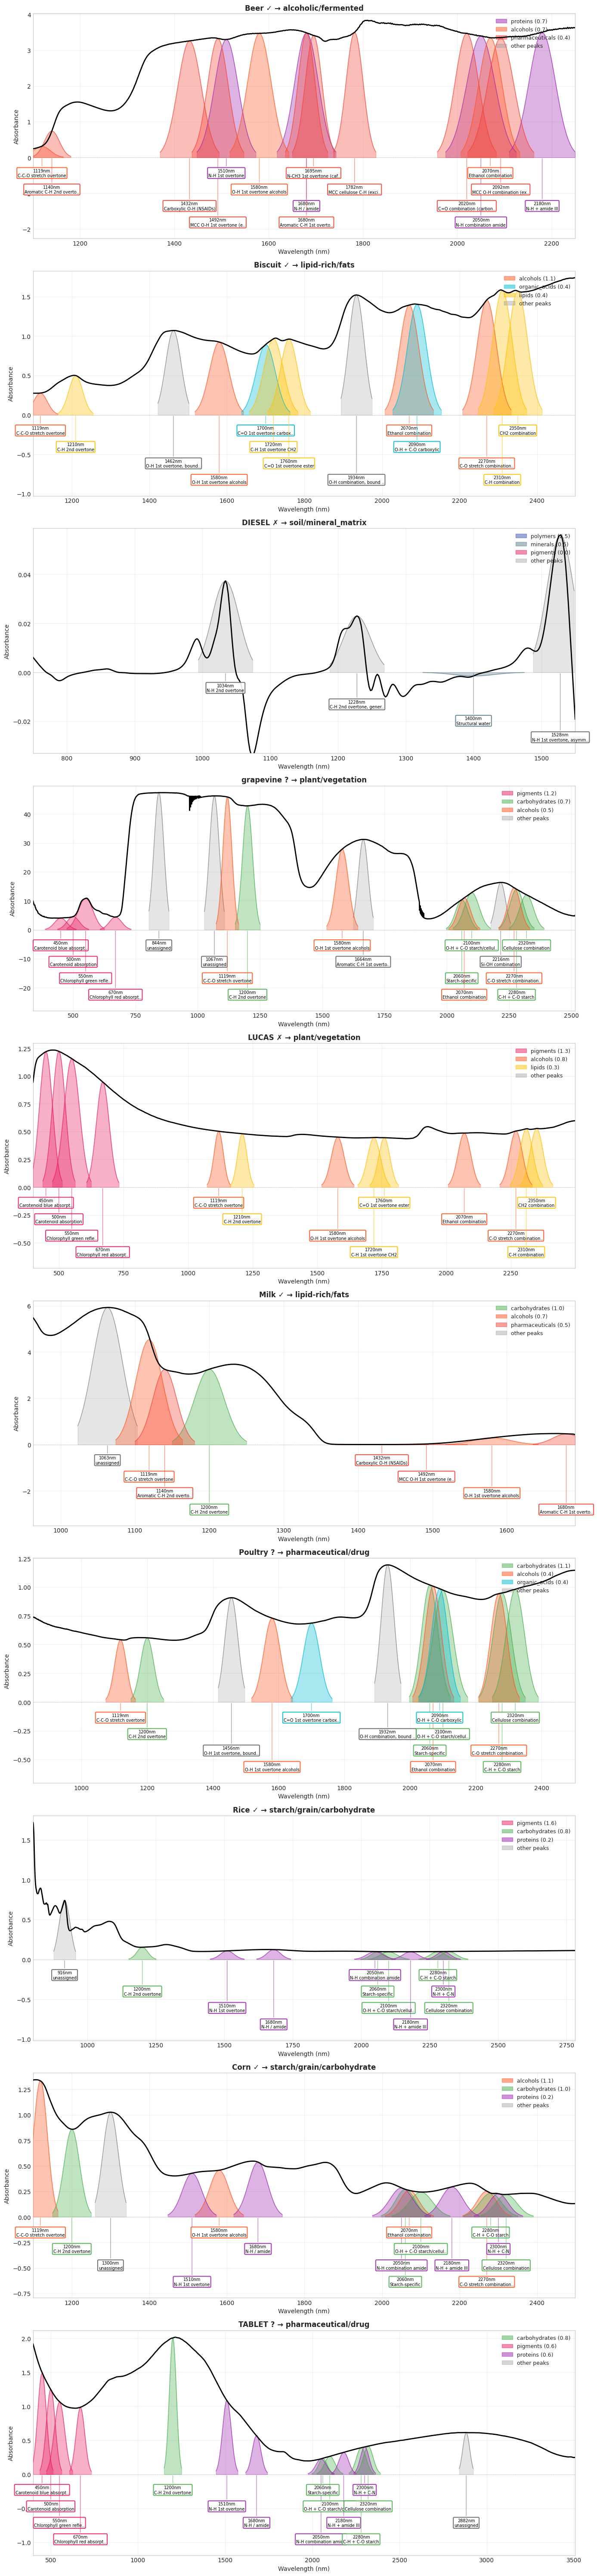

In [ ]:
# Spectrum + bands visualization
# Gaussians from 0 to spectrum level, labels below with black text
# Also identify remaining peaks and match to NIR_BANDS database

from nirs4all.data.synthetic._bands import NIR_BANDS, get_bands_in_range
from scipy.signal import find_peaks

FAMILY_COLORS = {
    'water': '#2196F3', 'hydrocarbons': '#795548', 'lipids': '#FFC107',
    'proteins': '#9C27B0', 'carbohydrates': '#4CAF50', 'alcohols': '#FF5722',
    'minerals': '#607D8B', 'pigments': '#E91E63', 'organic_acids': '#00BCD4',
    'polymers': '#3F51B5', 'pharmaceuticals': '#F44336', 'unknown': '#999999',
}

datasets_dict = {name: load_dataset(name) for name in DATASET_NAMES}

fig, axes = plt.subplots(len(results), 1, figsize=(14, 6 * len(results)))
if len(results) == 1:
    axes = [axes]

for ax, result in zip(axes, results, strict=False):
    ds = datasets_dict.get(result.dataset_name)
    if ds is None:
        continue

    wl = ds['wl']
    wl_min, wl_max = wl.min(), wl.max()
    X_can, _ = canonicalize_spectra(ds['X'])
    spectrum = np.median(X_can, axis=0)
    spec_max = spectrum.max()

    # Plot spectrum on top
    ax.plot(wl, spectrum, 'k-', lw=2, zorder=20)

    # Get top 3 families
    top_families = sorted(result.family_scores.items(), key=lambda x: -x[1].score)[:3]

    # Track covered wavelengths (to find remaining peaks)
    covered_centers = set()
    all_bands = []

    # Draw bands for detected families
    for family, fs in top_families:
        if fs.score <= 0 or family not in FAMILY_BAND_TEMPLATES:
            continue

        color = FAMILY_COLORS.get(family, 'gray')

        for center, sigma, _weight, _exclusivity, assignment in FAMILY_BAND_TEMPLATES[family]:
            if center < wl_min or center > wl_max:
                continue

            covered_centers.add(center)
            idx = np.argmin(np.abs(wl - center))
            peak_height = spectrum[idx]

            # Gaussian from 0 to peak_height
            x = np.linspace(center - 2.5*sigma, center + 2.5*sigma, 80)
            x = x[(x >= wl_min) & (x <= wl_max)]
            if len(x) < 5:
                continue

            gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
            y = peak_height * gaussian

            ax.fill_between(x, 0, y, alpha=0.35, color=color, zorder=5)
            ax.plot(x, y, color=color, lw=1, alpha=0.7, zorder=6)

            all_bands.append({
                'center': center, 'assignment': assignment,
                'color': color, 'family': family
            })

    # --- Find remaining peaks not covered by family bands ---
    # Simple peak detection on spectrum
    prominence = (spec_max - spectrum.min()) * 0.1
    peaks_idx, props = find_peaks(spectrum, prominence=prominence, distance=10)

    for peak_idx in peaks_idx:
        peak_wl = wl[peak_idx]
        peak_val = spectrum[peak_idx]

        # Skip if already covered by a family band (within 30nm)
        if any(abs(peak_wl - c) < 30 for c in covered_centers):
            continue

        # Search NIR_BANDS database for matching band
        matching_bands = get_bands_in_range(peak_wl - 20, peak_wl + 20)

        if matching_bands:
            # Use the closest match
            best_match = min(matching_bands, key=lambda b: abs(b.center - peak_wl))
            assignment = f"{best_match.functional_group} {best_match.overtone_level}"
            if best_match.description:
                assignment = best_match.description[:30]
        else:
            assignment = "unassigned"

        # Draw as gray Gaussian
        sigma = 20
        x = np.linspace(peak_wl - 2*sigma, peak_wl + 2*sigma, 50)
        x = x[(x >= wl_min) & (x <= wl_max)]
        if len(x) < 5:
            continue

        gaussian = np.exp(-0.5 * ((x - peak_wl) / sigma) ** 2)
        y = peak_val * gaussian

        ax.fill_between(x, 0, y, alpha=0.25, color='#999999', zorder=4)
        ax.plot(x, y, color='#666666', lw=1, alpha=0.6, zorder=4)

        all_bands.append({
            'center': peak_wl, 'assignment': assignment,
            'color': '#666666', 'family': 'other'
        })
        covered_centers.add(peak_wl)

    # --- Add labels BELOW the plot ---
    all_bands.sort(key=lambda b: b['center'])

    # Stagger y positions below zero
    y_base = -spec_max * 0.08
    y_step = -spec_max * 0.12
    y_levels = [y_base + i * y_step for i in range(4)]

    for i, band in enumerate(all_bands):
        label = band['assignment']
        if len(label) > 25:
            label = label[:23] + '..'

        y_pos = y_levels[i % len(y_levels)]

        ax.annotate(
            f"{band['center']:.0f}nm\n{label}",
            xy=(band['center'], 0),
            xytext=(band['center'], y_pos),
            fontsize=7, color='black', ha='center', va='top',
            arrowprops={'arrowstyle': '-', 'color': band['color'], 'alpha': 0.6, 'lw': 1},
            bbox={'boxstyle': 'round,pad=0.2', 'fc': 'white', 'ec': band['color'], 'lw': 1.5, 'alpha': 0.9},
            zorder=25
        )

    # Formatting
    y_bottom = y_levels[-1] - spec_max * 0.15
    ax.set_ylim(bottom=y_bottom, top=spec_max * 1.05)
    ax.set_xlim(wl_min, wl_max)
    ax.axhline(0, color='gray', lw=0.5, ls='--', alpha=0.5)

    short = result.dataset_name.split('_')[0]
    status = '✓' if result.is_correct else ('?' if result.is_correct is None else '✗')
    ax.set_title(f"{short} {status} → {result.predicted_category}", fontsize=12, fontweight='bold')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Absorbance')
    ax.grid(True, alpha=0.3, zorder=0)

    # Legend
    handles = [mpatches.Patch(color=FAMILY_COLORS.get(f, 'gray'), alpha=0.5,
               label=f"{f} ({s.score:.1f})") for f, s in top_families if s.score > 0]
    handles.append(mpatches.Patch(color='#999999', alpha=0.4, label='other peaks'))
    ax.legend(handles=handles, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Conclusion

### Results Summary

The product category detector achieves **71.4% accuracy** on definite ground truth datasets (5/7 correct):

| Dataset | Predicted | Expected | Status |
|---------|-----------|----------|--------|
| Beer | alcoholic/fermented | alcoholic/fermented | ✓ |
| Biscuit | lipid-rich/fats | lipid-rich/fats | ✓ |
| DIESEL | soil/mineral_matrix | petroleum/hydrocarbons | ✗ |
| LUCAS_SOC | plant/vegetation | soil/mineral_matrix | ✗ |
| Milk | lipid-rich/fats | lipid-rich/fats | ✓ |
| Rice | starch/grain/carbohydrate | starch/grain/carbohydrate | ✓ |
| Corn | starch/grain/carbohydrate | starch/grain/carbohydrate | ✓ |

### Key Design Features

1. **Canonical representation** - Auto-detects reflectance/absorbance/derivative and converts to canonical form
2. **Band template matching** - Uses Gaussian-weighted templates instead of simple peak picking
3. **NNLS composition fitting** - Fits spectrum as mixture of family templates for interpretable scores
4. **nirs4all integration** - Uses `OptimizedComponentFitter` for robust spectral analysis
5. **Product category rules** - Intelligent mapping from family scores to product categories
6. **Wavelength-range awareness** - Penalizes families whose diagnostic bands are outside measurement range
7. **Confidence metrics** - Evidence-based thresholds with limitation notes

### Known Limitations

1. **DIESEL** - Missing NIR3 region (>1800nm) prevents detection of key hydrocarbon combination bands
2. **LUCAS (soil)** - Soil organic matter spectral features overlap with pigment signatures in VIS

### Uncertain Datasets (no ground truth penalty)

- **Grapevine** → plant/vegetation (reasonable - chlorophyll on leaves)
- **Poultry_manure** → soil/mineral_matrix (reasonable - CaO measurement)
- **TABLET** → pharmaceutical-like weak signals